# Kaggle - House Price
주어진 집에 대한 정보를 이용하여 집값을 예측 하는 문제

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [47]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [48]:
tr = pd.read_csv("train.csv")
tst = pd.read_csv("test.csv")

tr.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [49]:
tst.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


트레인 셋과 테스트 셋이 Id를 기준으로 나뉘어 있다는 것을 알 수 있다. 전처리를 위해 두 데이터 셋을 합치고 나중에 모델에 적용할 때 Id 값을 통해 나누자

In [50]:
df = pd.concat([tr, tst])
label = tr["SalePrice"]

df.shape

(2919, 81)

먼저 범주형 데이터와 실수형 데이터를 나누어서 처리하자.

일반적으로 범주형 데이터는 문자열로 되어 있어 dtype 을 출력하면 object 가 나온다. 그러나 데이터 설명을 읽어보면 범주형 데이터임에도 숫자로 되어있는 데이터가 있다.

이에 해당되는 칼럼은 MSSubClass, OverallQual, OverallCond 이다.

In [51]:
catCols = list(filter(lambda x: str(df[x].dtypes) == "object", tr.columns)) + ["MSSubClass", "OverallQual", "OverallCond"]
catCols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass',
 'OverallQual',
 'OverallCond']

In [52]:
numCols = list(set(df.columns) - set(catCols) - set(["SalePrice", "Id"]))
numCols

['2ndFlrSF',
 'BsmtFullBath',
 'EnclosedPorch',
 '3SsnPorch',
 'GrLivArea',
 'HalfBath',
 '1stFlrSF',
 'PoolArea',
 'LotFrontage',
 'BsmtUnfSF',
 'MiscVal',
 'OpenPorchSF',
 'LotArea',
 'ScreenPorch',
 'WoodDeckSF',
 'BsmtHalfBath',
 'FullBath',
 'MoSold',
 'GarageArea',
 'YearBuilt',
 'BsmtFinSF1',
 'KitchenAbvGr',
 'MasVnrArea',
 'YrSold',
 'TotRmsAbvGrd',
 'BsmtFinSF2',
 'GarageCars',
 'BedroomAbvGr',
 'YearRemodAdd',
 'TotalBsmtSF',
 'Fireplaces',
 'GarageYrBlt',
 'LowQualFinSF']

In [53]:
df[numCols].shape, df[catCols].shape

((2919, 33), (2919, 46))

## 실수형 데이터

일단 결측치가 존재하는지 알아보자. 결측치가 많은 LotFrontage 와 GarageYrBlt 는 나중에 제거 대상이 될 수 있다.

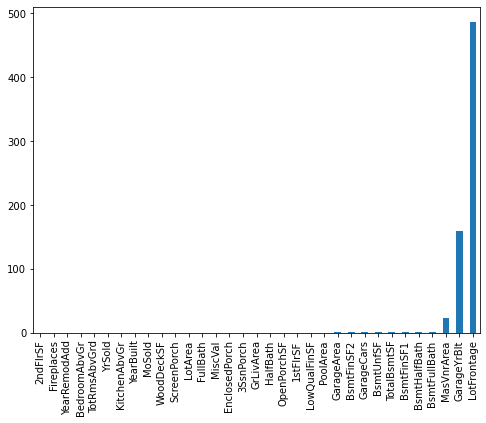

In [54]:
plt.figure(figsize=(8,6))
df[numCols].isna().sum().sort_values().plot.bar()
numCols = list(set(numCols) - set(["LotFrontage", "GarageYrBlt"]))
plt.show()

이 후 정규화 한다.

수치형 데이터와 SalePrice 간 상관관계를 살펴보자. 특별히 상관관계가 낮은 칼럼들이 존재한다. 이러한 칼럼들은 SalePrice 예측에 도움이 안 될 가능성이 높으니 삭제 할 대상이 될 수 있다.

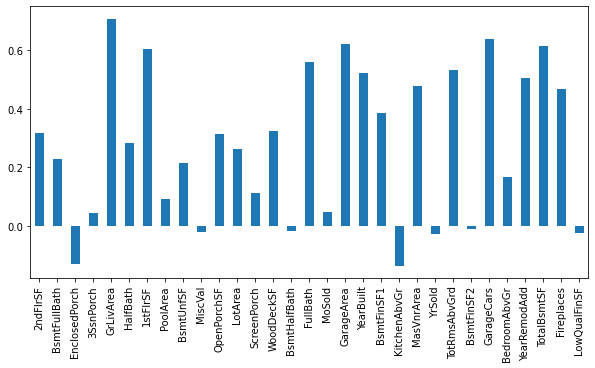

In [9]:
plt.figure(figsize=(10, 5))
tr.corr()["SalePrice"][numCols].plot.bar()
plt.show()

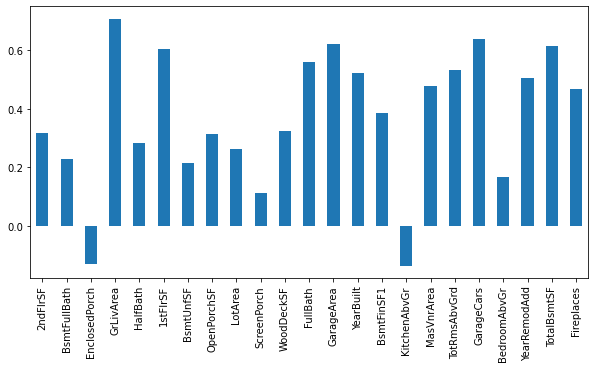

In [10]:
numCols = list(filter(lambda x: abs(tr.corr()["SalePrice"][x]) > 0.1, numCols))

plt.figure(figsize=(10, 5))
tr.corr()["SalePrice"][numCols].plot.bar()
plt.show()

다중공선성 확인을 위해 각각의 상관관계를 구해보자. 히트맵을 통해 눈에 띄게 상관관계가 높은 쌍이 몇가지 존재한다.

1. BedroomAbvGr 과 TotRmsAbvGrd 는 각각 침대방 개수와 전체 방 개수이기 때문에 상관관계가 높다. SalePrice 와의 상관관계가 더 큰 것은 TotRmsAbvGrd 이므로 BedroomAbvGr를 삭제 대상으로 둘 수 있다.
2. YearBuilt 와 YearRemodAdd 는 지어진 년도와 리모델링이 추가된 연도이다. 일반적으로 리모델링이 최근에 추가되었어도 오래된 집보다 새 집을 더 선호하므로 YearRemodAdd 를 삭제 대상으로 둘 수 있다.
3. GrLivArea 는 지하실을 제외한 Living Area 이다. Living Area 가 그 외 공간의 넓이보다 중요하기 때문에 이와 상관관계가 높은 1stFlrSF, 2ndFlrSF, TotRmsAbvGrd, FullBath를 삭제 대상으로 둘 수 있다.
4. BsmtFinSF1 은 지하실이 얼마나 좋은지에 대한 정보이고 BsmtFullBath 는 지하실 화장실 개수, BsmtUnfSF는 지하실에서 완성이 되지 않은 공간의 넓이다. BsmtFinSF1 에 지하실에 대한 정보가 함축되어 있을 것이기 때문에 BsmtFullBath, BsmtUnfSF를 삭제 대상으로 둘 수 있다.
5. GarageArea 는 차고 넓이, GarageCars는 차고에 수용할 수 있는 차량의 개수다. GarageCars 가 더 유의미하므로 GarageArea는 삭제 대상으로 둘 수 있다.

따라서 BedroomAbvGr, YearRemodAdd, 1stFlrSF, 2ndFlrSF, TotRmsAbvGrd, FullBath, BsmtFullBath, BsmtUnfSF, GarageArea 를 삭제 될 칼럼으로 볼 수 있다.

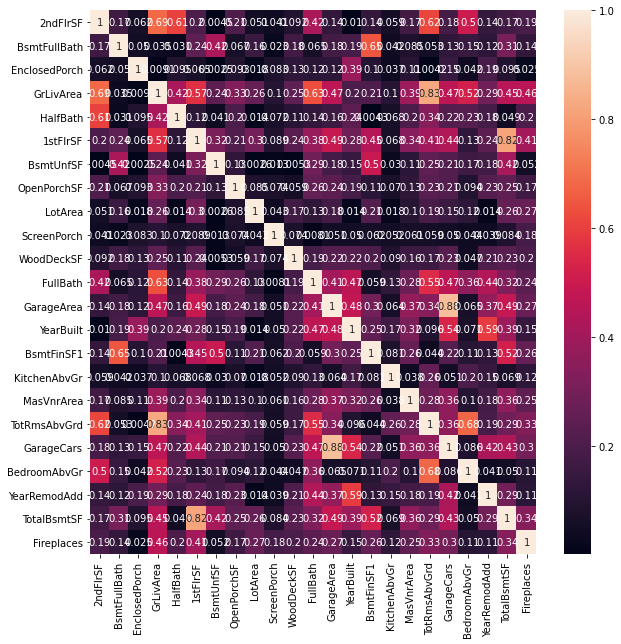

In [11]:
plt.figure(figsize=(10,10))
sn.heatmap(tr[numCols].corr().abs(), annot=True)
plt.show()

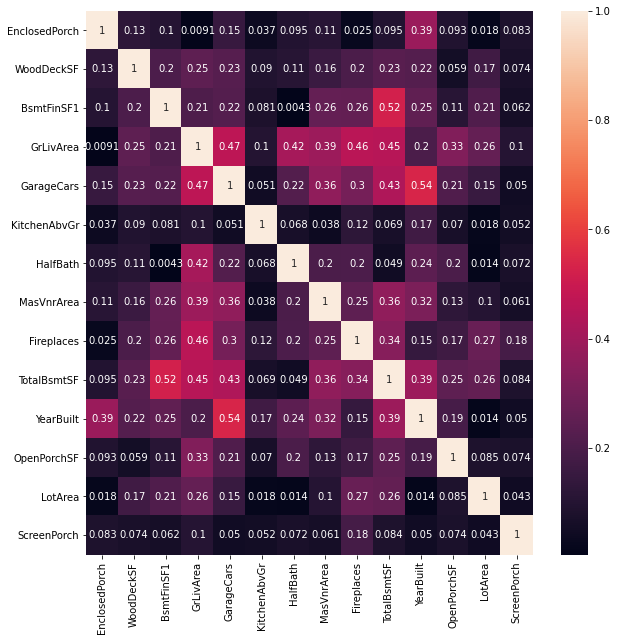

In [12]:
numCols = list(set(numCols) - set(["BedroomAbvGr", "YearRemodAdd", "1stFlrSF", "2ndFlrSF", "TotRmsAbvGrd", "FullBath", "BsmtFullBath", "BsmtUnfSF", "GarageArea"]))

plt.figure(figsize=(10,10))
sn.heatmap(tr[numCols].corr().abs(), annot=True)
plt.show()

### 범주형 데이터
결측치가 많은 열을 삭제 대상으로 둔다.

In [13]:
tr[catCols].isna().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
MSSubClass          0
OverallQual         0
OverallCon

In [14]:
catCols = list(filter(lambda x: tr[x].isna().sum() < 50, catCols))

tr[catCols].isna().sum()

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
Functional        0
PavedDrive        0
SaleType          0
SaleCondition     0
MSSubClass        0
OverallQual       0
OverallCond       0
dtype: int64

범주형 데이터들을 수치화 해야 하기 때문에 숫자로 바꿔준다. 이 때 기준은 SalePrice 와 비교하여 바꾼다. 예를 들면, MSZoning 같은 경우엔 SalePrice 와 비교 했을 때 C < RM < RH < RL <= FV 의 경향이 있다. 이를 숫자로 바꿀 땐 C -> 0, RM -> 1 ... 순으로 바꾸면 더욱 유의미한 수치가 될 수 있을 것으로 기대한다.

여기서는 평균값을 기준으로 바꾸겠다.

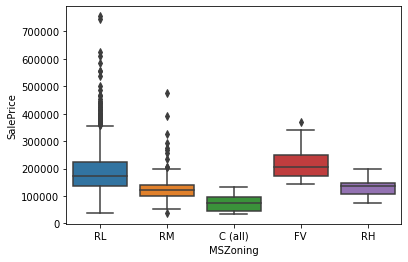

In [15]:
sn.boxplot(x="MSZoning", y="SalePrice", data=tr[["MSZoning", "SalePrice"]])
plt.show()

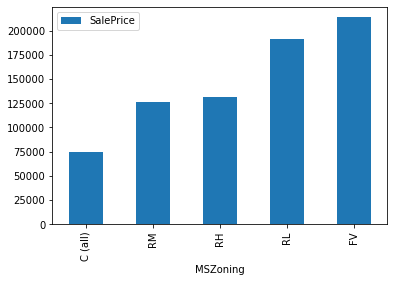

In [16]:
tr[["MSZoning", "SalePrice"]].groupby("MSZoning").mean().sort_values("SalePrice").plot.bar()
plt.show()

In [17]:
for col in catCols:
    keys = tr[[col, "SalePrice"]].groupby(col).mean().sort_values("SalePrice").apply(dict).to_dict()["SalePrice"].keys()
    keys = list(keys)
    tr[col] = tr[col].apply(lambda x: np.nan if x not in keys else keys.index(x))
    tst[col] = tst[col].apply(lambda x: np.nan if x not in keys else keys.index(x))
    df[col] = df[col].apply(lambda x: np.nan if x not in keys else keys.index(x))
    
df[catCols].dtypes

MSZoning         float64
Street             int64
LotShape           int64
LandContour        int64
Utilities        float64
LotConfig          int64
LandSlope          int64
Neighborhood       int64
Condition1         int64
Condition2         int64
BldgType           int64
HouseStyle         int64
RoofStyle          int64
RoofMatl           int64
Exterior1st      float64
Exterior2nd      float64
MasVnrType       float64
ExterQual          int64
ExterCond          int64
Foundation         int64
BsmtQual         float64
BsmtCond         float64
BsmtExposure     float64
BsmtFinType1     float64
BsmtFinType2     float64
Heating            int64
HeatingQC          int64
CentralAir         int64
Electrical       float64
KitchenQual      float64
Functional       float64
PavedDrive         int64
SaleType         float64
SaleCondition      int64
MSSubClass       float64
OverallQual        int64
OverallCond        int64
dtype: object

수치화 되었기 때문에 상관관계 분석을 해 볼 수 있다. 마찬가지로 상관관계가 너무 낮은 경우를 제거 대상으로 두자.

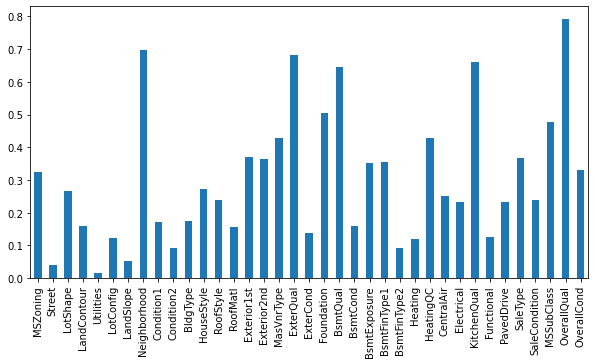

In [18]:
plt.figure(figsize=(10, 5))
tr.corr()["SalePrice"][catCols].plot.bar()
plt.show()

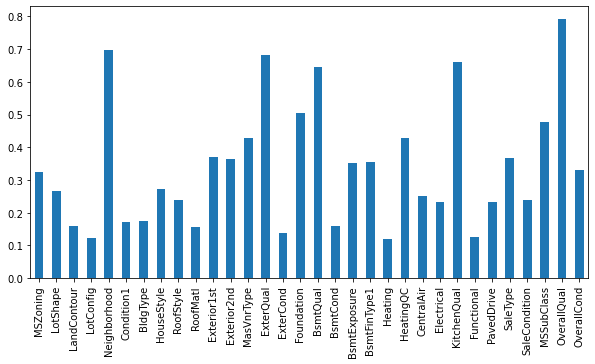

In [19]:
catCols = list(filter(lambda x: abs(tr.corr()["SalePrice"][x]) > 0.1, catCols))

plt.figure(figsize=(10, 5))
tr.corr()["SalePrice"][catCols].plot.bar()
plt.show()

상관관계가 눈에띄게 높은 OverallQual, Neighborhood, ExterQual, BsmtQual, KitchenQual 에 대해 boxplot 을 그려보자. 실제로 이 들은 집을 볼 때 중요한 요소임을 알 수 있다.

그래프를 보면 SalePrice 가 올라감에 따라 대부분 값이 증가함을 볼 수 있다. 그러나 이는 서로 상관관계가 높다는 의미도 되기 때문에 이들 중 일부를 삭제 해야 할 가능성도 있다.

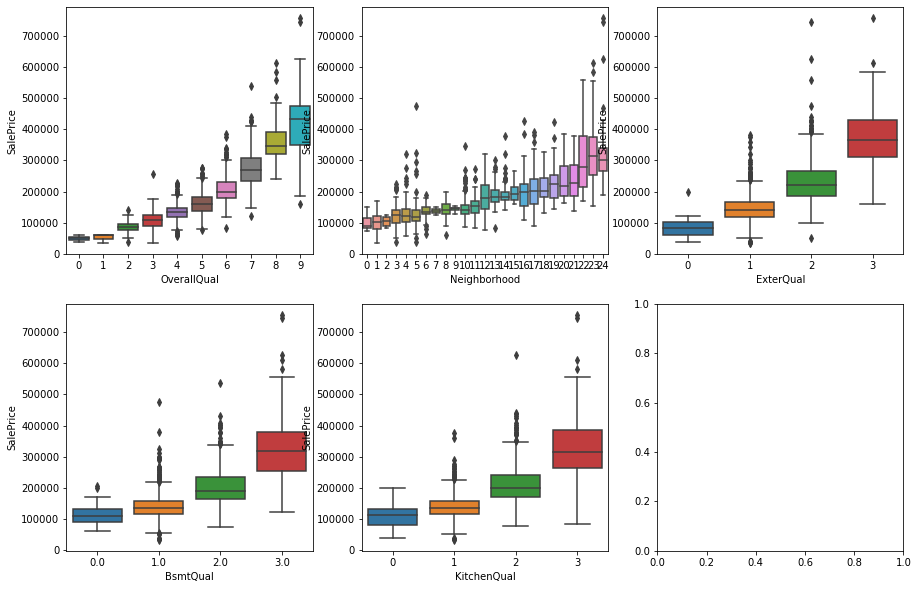

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for col, axis in zip(["OverallQual", "Neighborhood", "ExterQual", "BsmtQual", "KitchenQual", "end"], ax.flatten()):
    if col == "end":
        break
    sn.boxplot(x=col, y="SalePrice", data=tr[[col, "SalePrice"]], ax=axis)

plt.show()

상관관계 히트맵을 그려보자. 상관관계가 높은 칼럼들이 존재하는 것을 볼 수 있다.

1. Neighborhood, Foundation, ExterQual, BsmtQual, KitchenQual 은 모두 OverallQual 에 의해 설명되므로 삭제
2. Exterior1st 와 Exterior2nd 는 강한 상관관계가 있으므로 Exterior2nd 는 삭제

따라서 Neighborhood, Foundation, ExterQual, BsmtQual, KitchenQual, Exterior2nd 를 삭제한다.

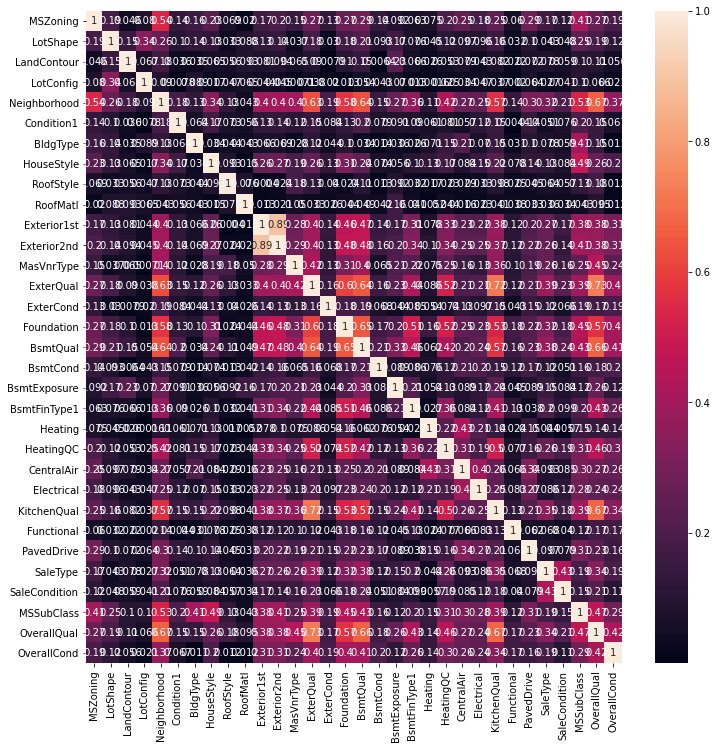

In [21]:
plt.figure(figsize=(12,12))
sn.heatmap(tr[catCols].corr().abs(), annot=True)
plt.show()

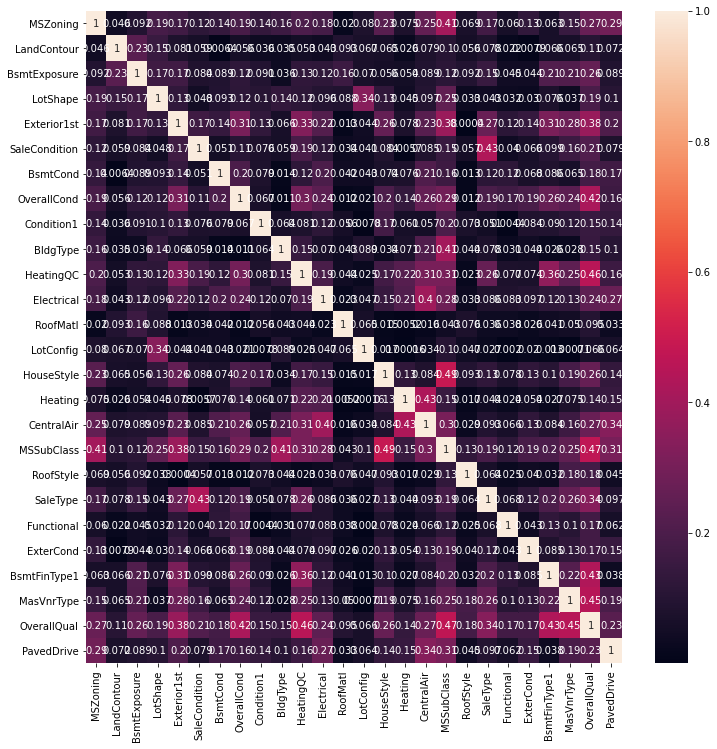

In [22]:
catCols = list(set(catCols) - set(["Neighborhood", "Foundation", "ExterQual", "BsmtQual", "KitchenQual", "Exterior2nd"]))
plt.figure(figsize=(12,12))
sn.heatmap(tr[catCols].corr().abs(), annot=True)
plt.show()

총 40개의 feature 가 남았다. 그러나 아직 범주형 - 실수형 사이에 상관관계가 높은 경우가 존재 할 수 도 있다. 그러나 40개의 feature 에 대한 상관관계 분석을 하는 것은 매우 어렵기 때문에 전처리 때 PCA 와 같은 방법으로 데이터를 줄이자.

In [23]:
len(numCols + catCols)

40

### 분포 확인
SalePrice 의 분포와 SalePrice 와 상관관계가 높은 몇가지 feature 의 분포를 알아보자.

1. SalePrice는 약간 right-skewed 되어 있다.
2. TotalBsmtSF가 0인 경우가 많다. 이 경우는 지하실이 아예 없는 경우로 보인다.
3. GrLivArea는 right-skewed 되어있다.
4. OverallQual은 SalePrice 와 달리 left-skewed 되어 있다. OverallQual 값이 SalePrice 에 비해 과대평가 되어 있을 가능성이 있다.

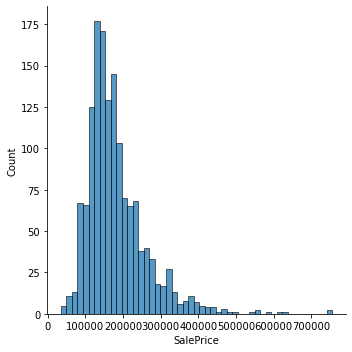

In [26]:
sn.displot(label)
plt.show()

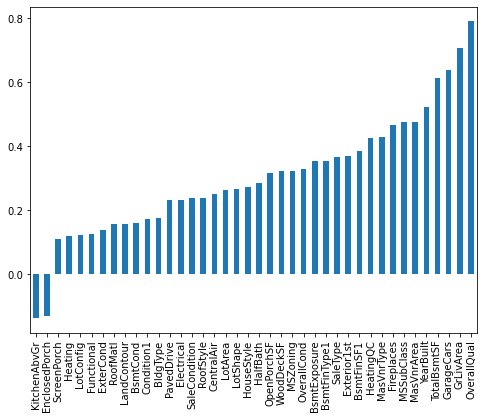

In [37]:
plt.figure(figsize=(8,6))
tr.corr()["SalePrice"][numCols + catCols].sort_values().plot.bar()
plt.show()

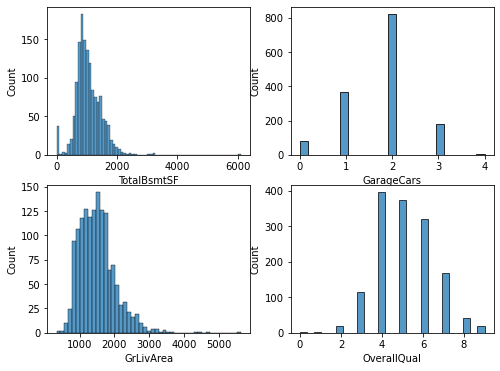

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

for col, axis in zip(["TotalBsmtSF", "GarageCars", "GrLivArea", "OverallQual"], ax.flatten()):
    sn.histplot(tr[col], ax=axis)
plt.show()